![iceberg-logo](https://www.apache.org/logos/res/iceberg/iceberg.png)

# Icebergの仕組みを理解しよう

## 本章のねらい：
- **Icebergの基本的なアーキテクチャを理解する**  
- **実際のメタデータとデータの動きを手を動かしながら観察して理解を深める**  

## Introduction

本章では、Icebergを構成するメタデータとデータの内部構造を理解することを目指します。  
これらを理解することで、Icebergの高速性や、Time TravelやSchema Evolution、同時アクセス制御などが何故/どのように実現されているのかが分かるようになります。  

### Icebergの本質はTable仕様である

最初に理解していただきたいのは、Icebergの本質はストレージエンジンでもクエリエンジンでもなく、Table仕様であるということです。  
Iceberg自体はテーブルフォーマットの仕様に過ぎず、それ自体が特定のソフトウェアやプロセスを指すものではありません。 
  
つまり、実際にIceberg Tableを扱うのはSparkやTrino, Hiveなどのエンジンであって、各エンジンがIcebergのTable仕様の約束に従ってデータ/メタデータを書き込み/読み取りすることでIcebergの機能が実現されるということです。  
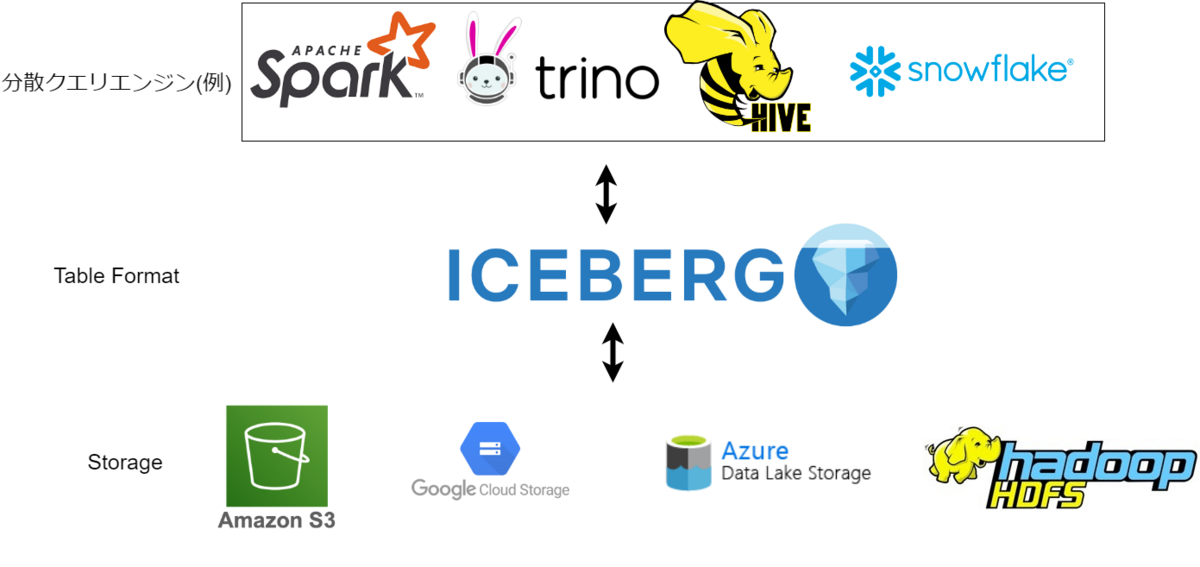  

IcebergのTable仕様は以下に定義されており、ここに書いてあることが一義的な「Icebergの仕組み/機能」ということになります。  
[Iceberg Table Spec](https://iceberg.apache.org/spec/)

ただし、それらをどこまで/どのように実現するかは各エンジン側のサポート、実装次第であるため、Table仕様に書いてあることが必ずしも各エンジンで実現できるとは限らない点に注意が必要です。  
従って、Icebergを理解/検討する上ではTable仕様と、利用しようとしているエンジンの仕様の両方を把握しておく必要があります。 

ただし、主要なエンジンにIcebergを組み込むためのライブラリはIcebergプロジェクト側で開発されており、core Java libraryに加えて、go、python、Rust実装も開発が進んでいます。
https://github.com/apache/iceberg

### Icebergのアーキテクチャ

Icebergは大きく3つのレイヤーで構成され、以下の画像のような木構造になっています。(この画像は[Iceberg Table Spec](https://iceberg.apache.org/spec/)に掲載されているもので、Icebergについて説明する様々な資料で必ずと言っていいほど出てくるので、是非覚えてください) 
- カタログ
- メタデータ層
- データ層

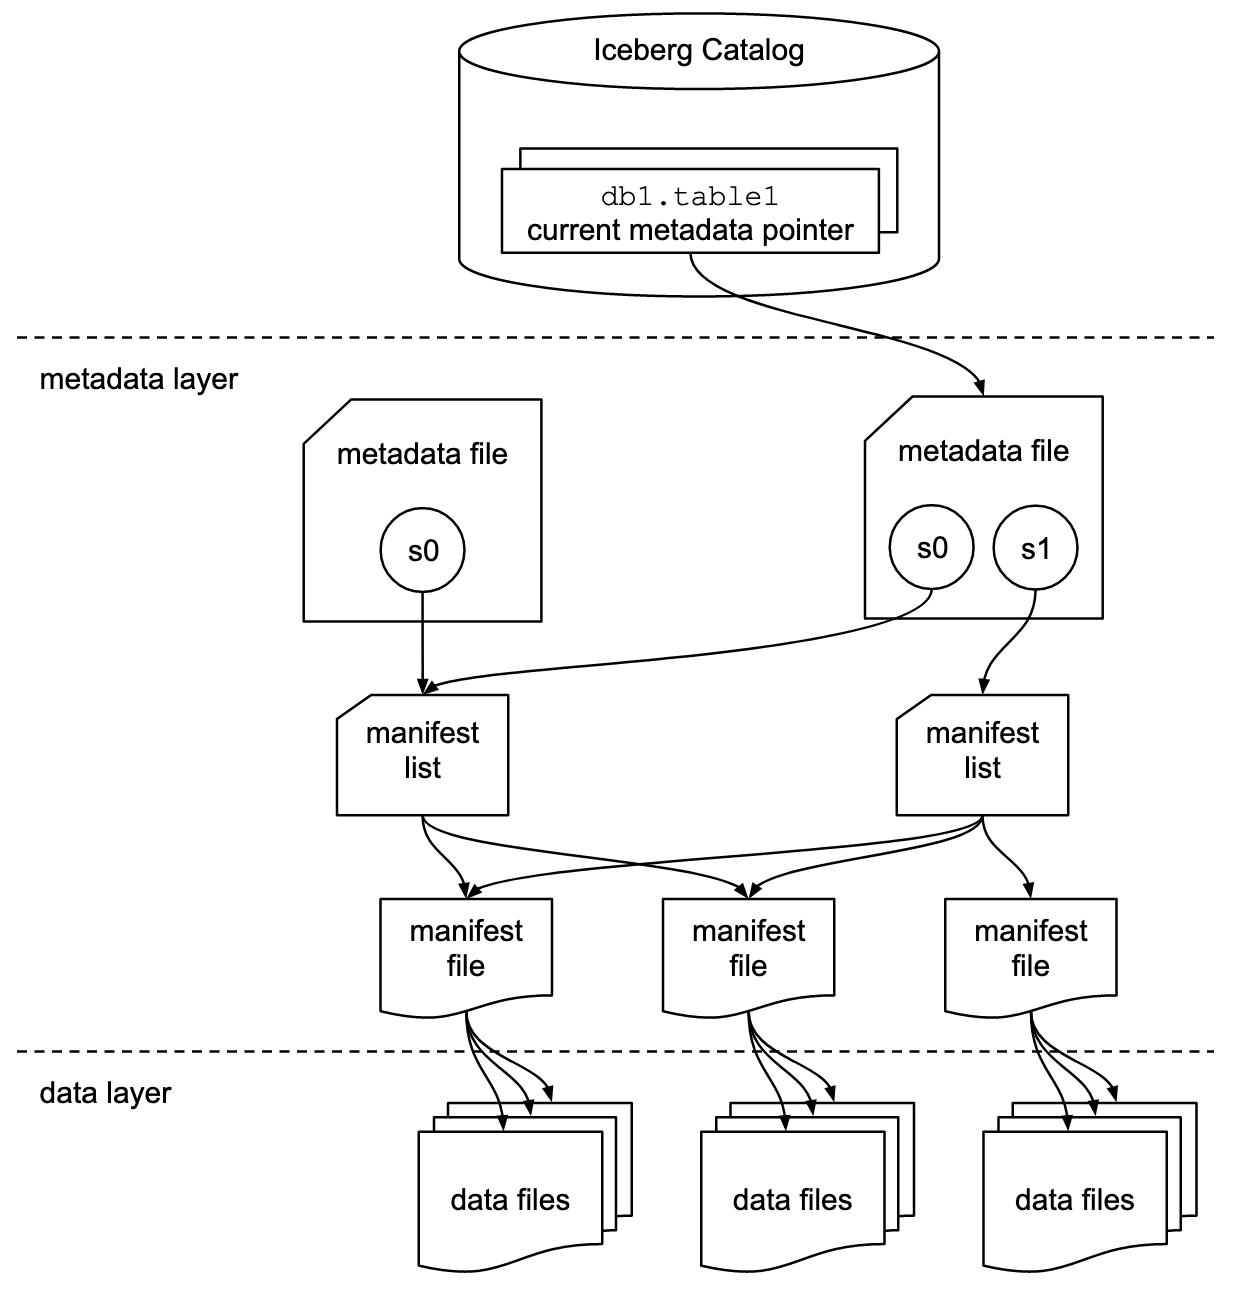

#### Iceberg Catalog
現在の最新断面のメタデータが格納されているmetadata fileのロケーションをポイントします。  

Reader, WriterはIceberg Catalogを参照することでテーブルの最新の状態(metadata file)を把握して、それを起点にmetadata fileの木構造を下っていきます。

Catalogに求められる基本的な要件はテーブルパス（例えば "db1.table1"）をテーブルの現在の状態を持つmetadata fileのロケーションにマッピングすることであるため、実装方法の選択肢は多様にあります。ただし、同時書き込みが発生した場合の整合性の確保、つまりreader,writerがある時点において同じ状態のtableを参照できることを保証するためには、metadataのポインタをAtomicに更新できなければなりません。 
  
また、Catalog実装によっては複数のテーブル、ステートメント間のトランザクションなどの付加的な機能を実現するものもあります。  
Iceberg Catalog実装の選択肢についての詳細は以下をご参照ください。   
[Apache Iceberg Catalog選択のポイント](https://speakerdeck.com/bering/apache-iceberg-catalogxuan-ze-nohointo-b44726a4-a8c8-49fc-9f06-7eb5729c9d7d)  
  
なお、本ハンズオンの環境ではTabularが開発したREST Catalog実装が使用されています。  
https://github.com/tabular-io/iceberg-rest-image

#### Metadata Layer
Metadata Layerはmetadata files,manifest lists,manifest filesの3階層に分かれます。  
これらはテーブルに対する全てのオペレーションを追跡しており、これらによってTimetravelクエリやSchema Evolutionなどが実現されます。  
metadata layerのファイル群はData Layerと同じように、HDFSのような分散ファイルシステムや、Amazon S3, Azure Storage, Google Cloud Storageなどのスケーラブルなオブジェクトストレージに保管できます。  
本ハンズオンの環境ではAmazon S3互換のオブジェクトストレージであるminIOに保管しています。

#### metadata file
テーブルのスキーマ情報、パーティション情報などに加えて、テーブルの有効なスナップショットのリストと、最新断面のスナップショットの情報を保持するjsonファイルです。  
ファイル名は、 v***.metadata.jsonまたは、***-<random-uuid>.metadata.jsonとなります。  

Icebergテーブルが変更されるたびに新たなmetada fileが生成されます。同時に、Iceberg Catalogは津年に最新のmetadata fileのロケーションをポイントします。  

これによって、Icebergの同時実行制御の仕組みが実現します。  
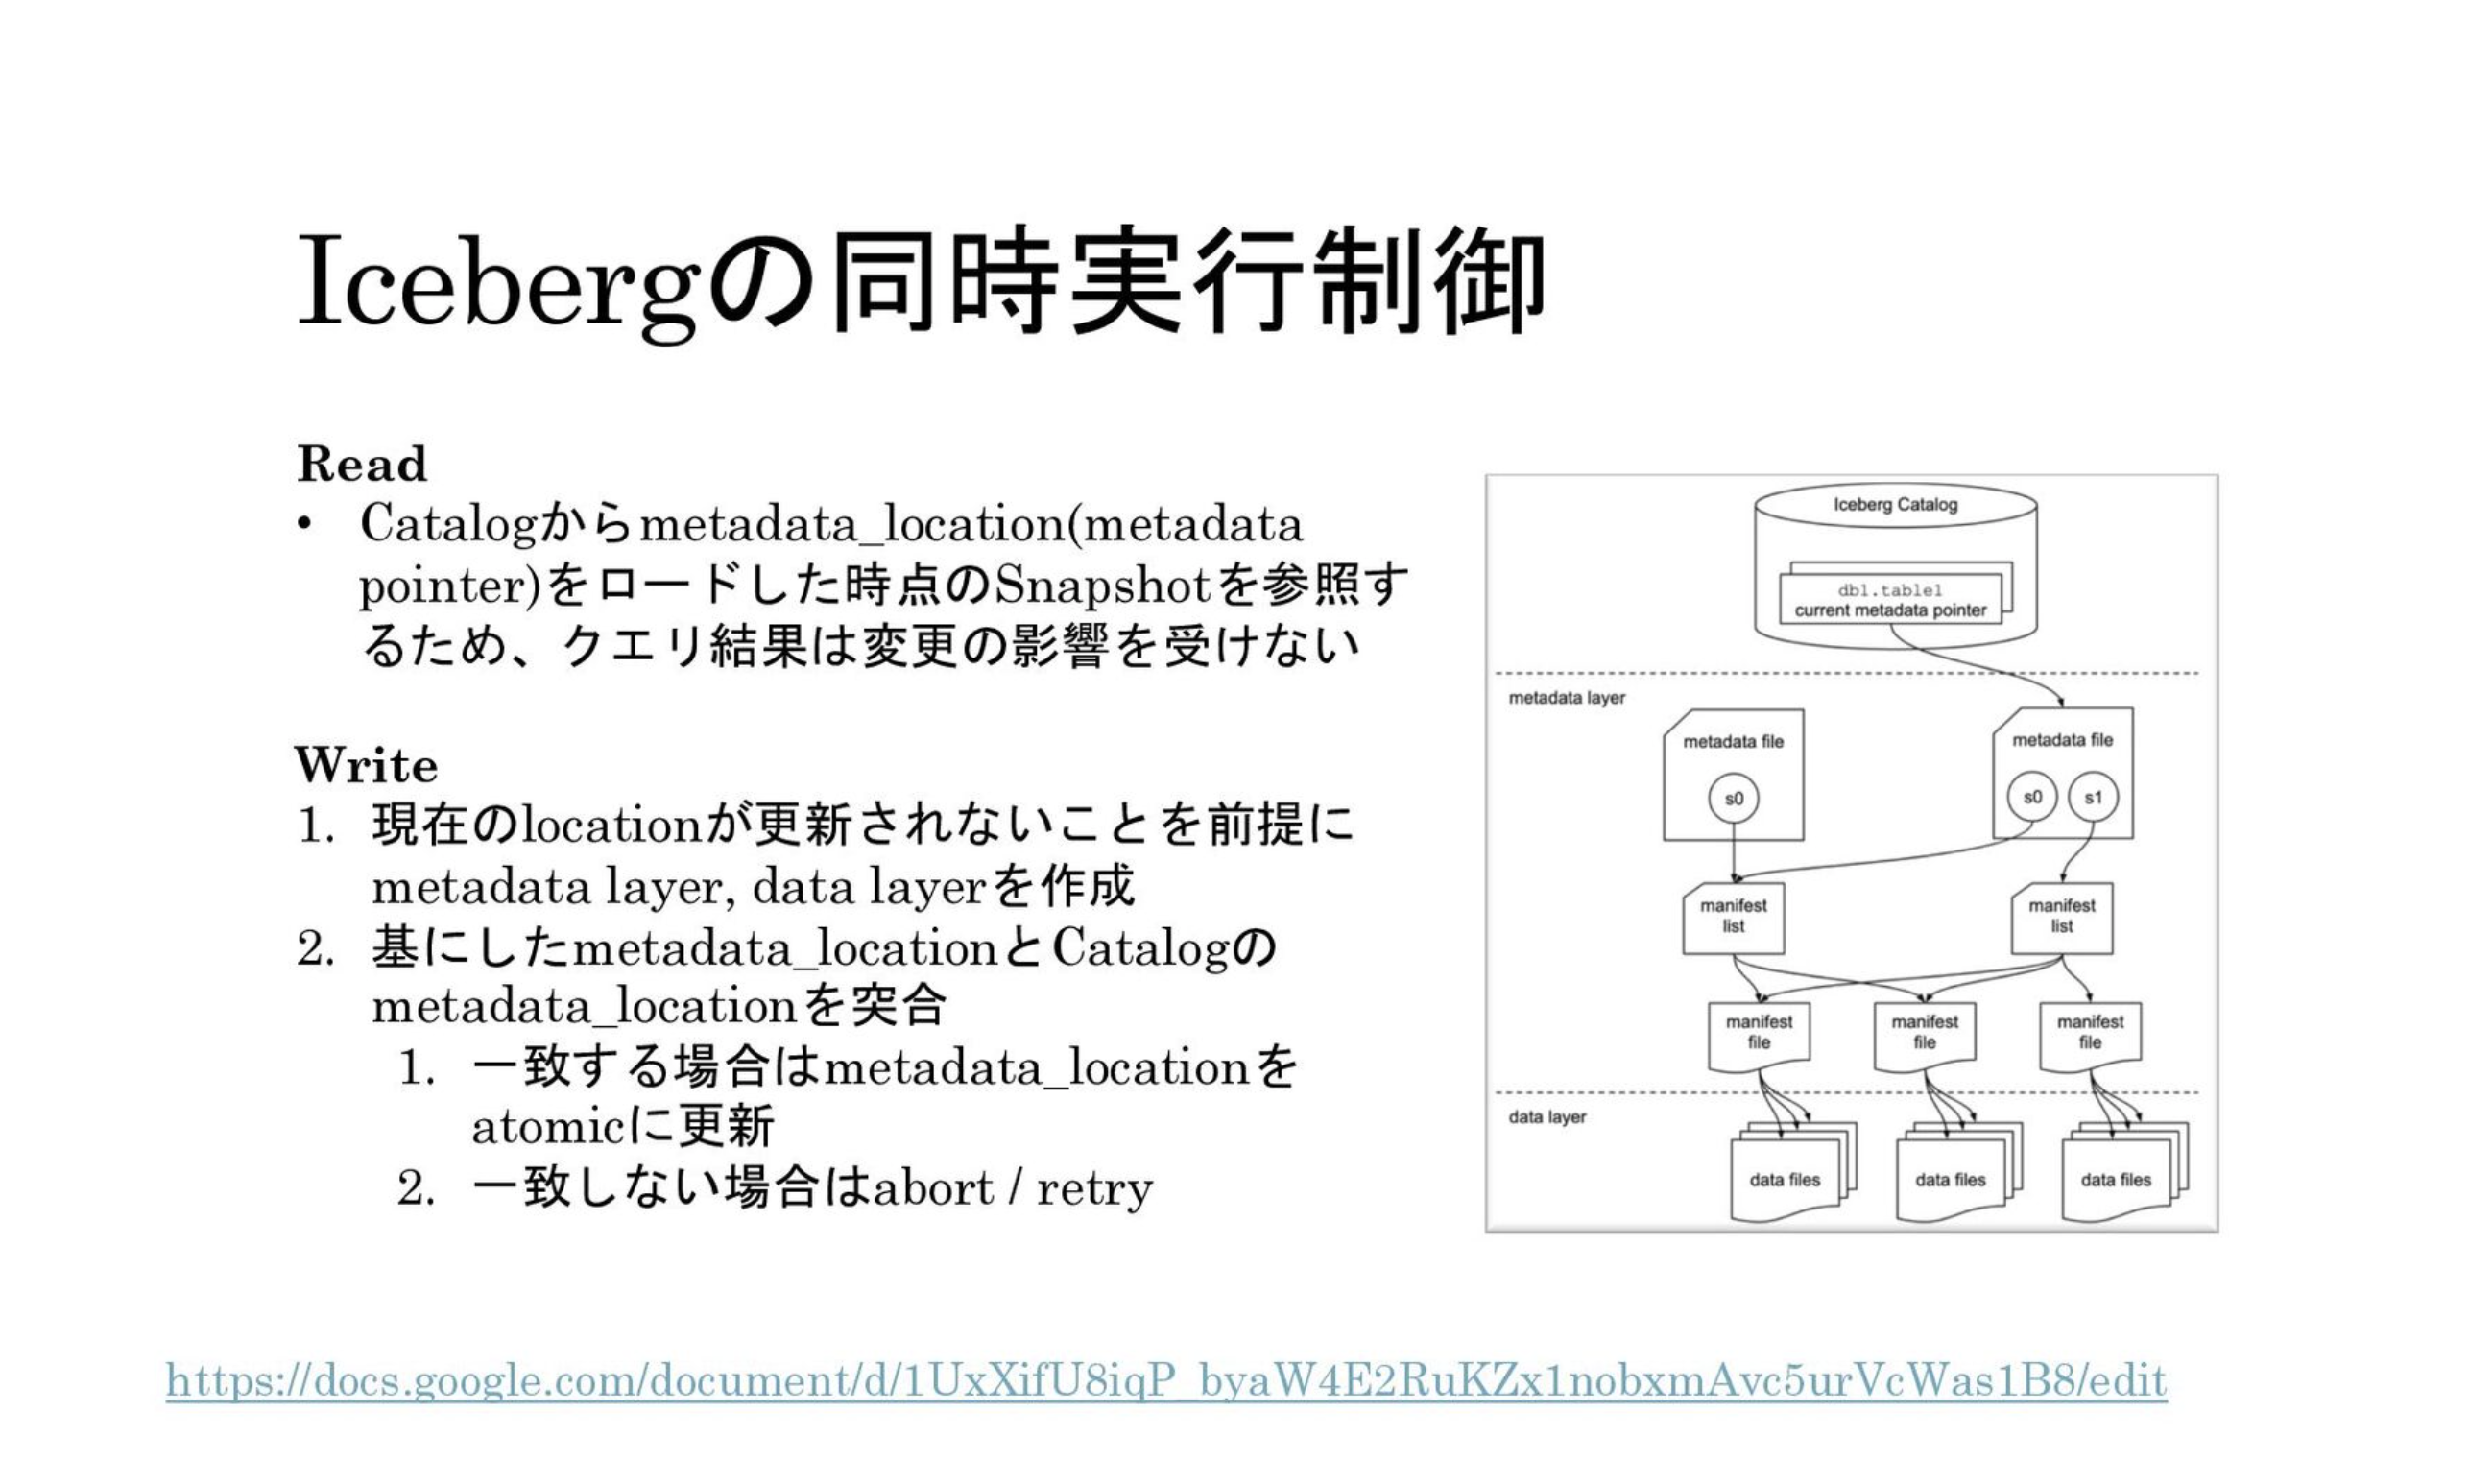

metadata fileの仕様の詳細は以下を参照してください。  
https://iceberg.apache.org/spec/#table-metadata-and-snapshots

#### manifest list
ある時点におけるIcebergテーブルのスナップショットを管理するavroファイルです。  
ファイル名はsnap-***.avroです。  

自身が管理するSnapshotに紐づくすべてのmanifest fileのリスト（場所、所属するパーティション、manifest fileが追跡するdata fileのパーティション列の上限と下限）を含んでいます。  
  
クエリエンジンがIcebergテーブルへのクエリを計画する際、manifest list内のパーティションや統計情報を参考にすることで、スキャン対象のメタデータ/データを最小限に絞れます。

#### manifest file
data layer内のファイル(データファイル、削除ファイル、Puffinファイル)を追跡して、各ファイルに関する追加の詳細や統計情報を保持します。  
ファイル名は***.avroです。  

クエリエンジンはmanifest fileの内容を元に、読み込み対象のファイルをプルーニング(最適化)して、クエリ効率を向上します。  
実はこの点がHiveテーブルとの大きな違いで、Icebergは統計情報をカタログではなくmanifest filesに保持して、data fileのサブセットに対する小さなバッチで書き込むことで統計情報の更新を軽量化しています。

### data Layer

data Layerには、テーブルのレコードデータ本体であるdata fileに加えて、Icebergの高度な仕組みを実現するのに必要なdelete file, puffin fileの3種類が存在します。  
本章では、その中でも最も基本的なdata fileのみを紹介します。

#### data file

data filesはtableのデータそのもので、Apache Parquet, Apache ORC, and Apache Avroでの形式がサポートされています。  
ファイル形式は選択可能で、大規模なOLAP分析にはParquet、低レイテンシなストリーム処理にはAvroを用いる、といった使い分けが可能です。  
特に、同一テーブル内で複数のファイル形式を持つことも可能です。従って、細かいデータを断続的に書き込むストリーミングのユースケースではレコードレベルの書き込み性能に優れたAvroを使用し、その後テーブルへのクエリを行う際に後から大量データの読み込み性能に優れたParquetに変換する、といったことが出来ます。 

## ハンズオン
ここからは実際に手を動かしながら、ここまでに紹介したIcebergのアーキテクチャを体感していきます。

### 前準備

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Jupyter").getOrCreate()

spark

In [ ]:
%%sql

CREATE DATABASE IF NOT EXISTS nyc

In [ ]:
%%sql
-- ノートブックを何度も再実行できるようにするために、テーブルが存在する場合は削除する
DROP TABLE IF EXISTS nyc.taxis PURGE

以降の手順でminIO上のファイルを参照するため、boto3のS3クライアントを用意します。  
(手順をJupyter内で完結させるためにS3クライアントで操作しますが、適宜minIOの管理GUI`http://localhost:9001/browser`から参照しても構いません)  
  
＊実際にはS3を使用せず、ローカル上のminIOにアクセスしている点に注意してください。minIOはS3互換のオブジェクトストレージであるため、以下のようにboto3から操作できるのです) 
  
＊コード内にminIOのクレデンシャルをハードコードしていますが、**これを本番環境で真似しないでください。**  
これはローカルのハンズオン環境に接続するための簡易的な措置であり、コード内へのクレデンシャルのハードコードは非常にバッドなプラクティスです。本番向けには最低限環境変数に保持するか、適切なシークレットマネージャを使用してください。

In [ ]:
import boto3
import json

# Minioサーバーの設定
minio_endpoint = 'http://minio:9000'
minio_access_key = 'admin'
minio_secret_key = 'password'
bucket_name = 'warehouse'

# S3クライアントを作成
s3 = boto3.client('s3',
                  endpoint_url=minio_endpoint,
                  aws_access_key_id=minio_access_key,
                  aws_secret_access_key=minio_secret_key,
                  verify=False)

# バケットのリストを取得
response = s3.list_buckets()
print("Buckets:")
for bucket in response['Buckets']:
    print(f"- {bucket['Name']}")

### CREATE TABLEしてみる
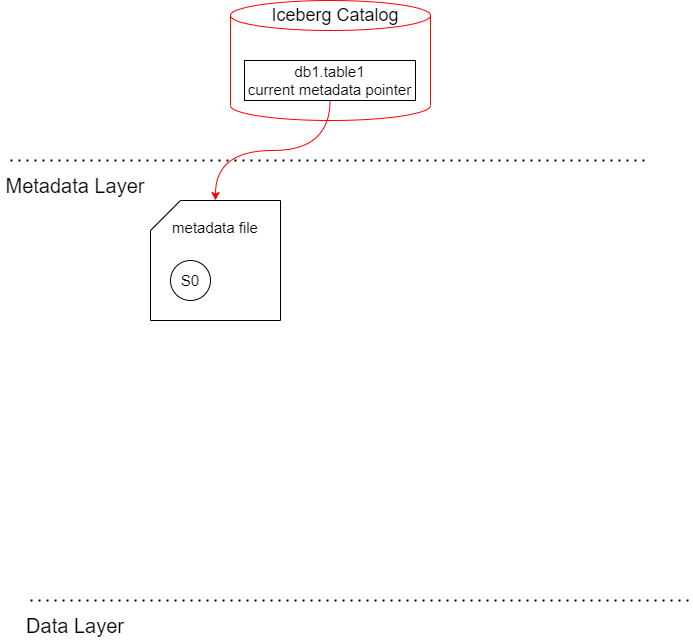

In [ ]:
%%sql

CREATE TABLE IF NOT EXISTS nyc.taxis (
      VendorID BIGINT,
      tpep_pickup_datetime TIMESTAMP_NTZ,
      tpep_dropoff_datetime TIMESTAMP_NTZ,
      passenger_count DOUBLE,
      trip_distance DOUBLE,
      RatecodeID DOUBLE,
      store_and_fwd_flag STRING,
      PULocationID BIGINT,
      DOLocationID BIGINT,
      payment_type BIGINT,
      fare_amount DOUBLE,
      extra DOUBLE,
      mta_tax DOUBLE,
      tip_amount DOUBLE,
      tolls_amount DOUBLE,
      improvement_surcharge DOUBLE,
      total_amount DOUBLE,
      congestion_surcharge DOUBLE,
      airport_fee DOUBLE
    )
    LOCATION "s3://warehouse/nyc/taxis"
    TBLPROPERTIES ('table_type'='ICEBERG')
    ;

MinIOの`warehouse/nyc/taxis/metadata`を見ると、`**.metadata.json`が作られています。これが先述のmetadata fileです。

In [ ]:
s3.list_objects_v2(Bucket=bucket_name, Prefix='nyc/taxis/metadata/')['Contents']

ファイルの中を見ると、カラムやデータ型などのスキーマ情報が格納されていることが分かります。  
今の時点ではスキーマを定義したのみで実際のデータは格納されていないため、snapshotsは空になっています。

In [ ]:
# Keyには自分の環境の**.metadata.jsonを指定してください
response  = s3.get_object(Bucket=bucket_name, Key='nyc/taxis/metadata/00000-eba400da-fcf6-4f88-b681-79c61caef3fe.metadata.json')
content = response['Body'].read().decode('utf-8')
json.loads(content)

### INSERTしてみる
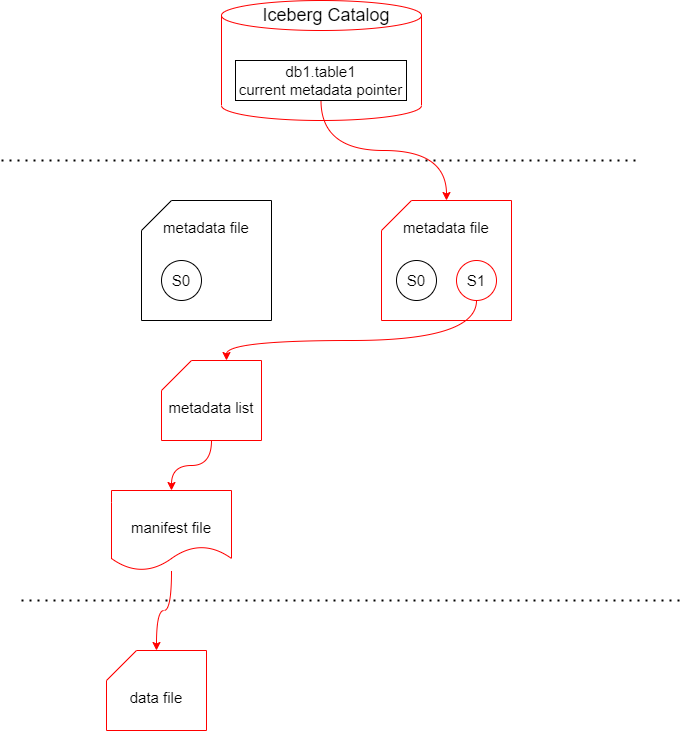

In [ ]:
%%sql

INSERT INTO nyc.taxis VALUES
  (1, CAST('2023-03-01 08:00:00' AS TIMESTAMP_NTZ), CAST('2023-03-01 08:15:00' AS TIMESTAMP_NTZ), 1, 3.5, 1, 'N', 263, 161, 1, 12.5, 0.5, 0.5, 2.0, 0, 0.3, 15.8, 0, 0),
  (2, CAST('2023-03-01 09:00:00' AS TIMESTAMP_NTZ), CAST('2023-03-01 09:20:00' AS TIMESTAMP_NTZ), 2, 2.8, 1, 'N', 186, 230, 2, 10.0, 0.5, 0.5, 0, 0, 0.3, 11.3, 2.5, 0),
  (1, CAST('2023-03-01 10:00:00' AS TIMESTAMP_NTZ), CAST('2023-03-01 10:10:00' AS TIMESTAMP_NTZ), 1, 1.7, 1, 'N', 164, 161, 1, 8.0, 0.5, 0.5, 1.5, 0, 0.3, 10.8, 0, 0)

In [ ]:
%%sql

SELECT * from nyc.taxis

改めて`nyc/taxis/metadata/`を見てみると、3つのファイルが作られています。  
- 新しい`**.metadata.json`(manifest file)
- `snap-**.avro`(manifest list)
- `**.avro`(metadata file)

In [ ]:
s3.list_objects_v2(Bucket=bucket_name, Prefix='nyc/taxis/metadata/')['Contents']

それぞれの中身を見てみましょう。まずはmanifest fileです。

テーブル作成直後の`**.metadata.json`と比較すると、以下のことが分かります。  
- last-sequence-numberの値
  - 1つ目のJSONでは"last-sequence-number": 0
  - 2つ目のJSONでは"last-sequence-number": 1  

これはmanifest fileのバージョンがインクリメントされたことを意味します。

- current-snapshot-id、refs、snapshots、snapshot-log、metadata-logの値が入っている

INSERTを行ったスナップショット(manifest list)が記録されていることが分かります。

In [ ]:
# Keyには自分の環境の、タイムスタンプが新しい方の**.metadata.jsonを指定してください
response  = s3.get_object(Bucket=bucket_name, Key='nyc/taxis/metadata/00001-121d4740-061f-474a-9aa8-54c9df81bd58.metadata.json')
content = response['Body'].read().decode('utf-8')
json.loads(content)

それでは、manifest listはどうなっているでしょうか？  
`snap-**.avro`を見ると、INSERT後のスナップショットのmanifest fileのパスと、レコード数などの情報が入っていることが分かります。

In [ ]:
import io
from avro.datafile import DataFileReader
from avro.io import DatumReader
# Keyには自分の環境のsnap-**.avroを指定してください
response  = s3.get_object(Bucket=bucket_name, Key='nyc/taxis/metadata/snap-1043677124961658170-1-6fdbec09-a665-4aba-918b-600c910b60e2.avro')
content = response['Body'].read()
bytes_stream = io.BytesIO(content)
reader = DataFileReader(bytes_stream, DatumReader())

In [ ]:
#snap-**.avroのスキーマ情報
schema = reader.schema
print(schema)

In [ ]:
#snap-**.avroの中身
for record in reader:
    print(record)

最後に、manifest fileも見てみましょう  
`**.avro`を見ると、先ほどINSERTした3つのレコードについて以下の情報が格納されていることが分かります。  

- file_path: データファイルのS3上のパス
- file_format: データ形式 (PARQUET)
- record_count: ファイル内のレコード数
- file_size_in_bytes: ファイルサイズ (バイト)
- column_sizes: 各カラムのデータサイズ
- value_counts: 各カラムの値の個数
- null_value_counts: 各カラムのNULL値の個数
- nan_value_counts: 各カラムのNaN値の個数
- lower_bounds: 各カラムの最小値
- upper_bounds: 各カラムの最大値

クエリエンジンはこれらの情報をうまく使うことで、効率的に実データにアクセスすることが出来るのです。

In [ ]:
import io
from avro.datafile import DataFileReader
from avro.io import DatumReader
# Keyには自分の環境の**.avroを指定してください
response  = s3.get_object(Bucket=bucket_name, Key='nyc/taxis/metadata/6fdbec09-a665-4aba-918b-600c910b60e2-m0.avro')
content = response['Body'].read()
bytes_stream = io.BytesIO(content)
reader = DataFileReader(bytes_stream, DatumReader())

In [ ]:
#**.avroのスキーマ情報
schema = reader.schema
print(schema)

In [ ]:
#snap-**.avroの中身
for record in reader:
    print(record)